**ENLR**

This section contains the details to get the radius of ENLR.

In [1]:
%matplotlib inline
# autoload the package, for debuge purpose
%load_ext autoreload
%autoreload 2

# import modules and plot setting
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
import datetime
from astropy.table import Table
from astropy.io import fits
from mangatools.manga import MaNGA
from mangatools.maps import Maps
from mangatools import utils

today = datetime.date.today().isoformat()

# set the display properties

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

# customize the warning message
import warnings
warnings.filterwarnings("default") # default or ignore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Global SAS directory is /Volumes/Lacie2


# Elliptical Isophot Fitting

In [ ]:
# functions for do Monte-Carlo simulation for map
from numpy import ma
import numpy as np


def mock_map(sigma, repeats=1000):
    # generate mock error map for give sigma map
    try:
        a, b = sigma.shape
    except:
        return 0
    noise_map = np.zeros((repeats, a, b))
        
    for i in range(a):
        for j in range(b):
            noise_map[:,i,j] = np.random.randn(repeats) * sigma[i,j]
    if ma.is_masked(sigma):
        mask = np.repeat(sigma.mask[np.newaxis, :,:], repeats, axis=0)
        return ma.masked_array(noise_map, mask=mask)
    return noise_map

In [3]:
### Define functions for ellispe fitting
# History:
#   2018-10-05: add history

from astropy.io import fits
from scipy.ndimage import binary_closing, binary_opening
from matplotlib import colors
from photutils.isophote import Ellipse, EllipseSample
from photutils.isophote import EllipseGeometry
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from photutils import EllipticalAperture


def fitEllipse(fmap, init='auto', step=0.2, plot=False, ax=None, n=5,
               fs=8, mini=False, showColorbar=True, showContour=True,
               lw=1, maxiter=1000, quiet=False):
    """for manga data, 0.5 arcsec for each pixels
    fmap: flux map
    init: [sma, eps, pa]
    ellipse: 'auto': using the Ellipse fitting algrithm in photoutil
             'annuli': fitting using the different Re annuli
    """
    if not quiet:
        print('init:', init)
    # get the length and width of the flux map
    x0 = np.arange(0, fmap.shape[0])
    y0 = np.arange(0, fmap.shape[1])
    # get the approximate radius of non-zero flux map
    rx, ry = np.where(fmap > 0) # index equal to the pixel size
    r_max = np.max([np.abs(rx - x0.mean()), np.abs(rx - y0.mean())])
    fitted = False
    
    if not isinstance(init, str):
        try:
            sma, eps, pa = init
            geometry = EllipseGeometry(x0=x0.mean(), y0=y0.mean(), sma=sma, eps=eps, pa=pa)
            ellipse = Ellipse(fmap, geometry, threshold=0.01)
            isolist = ellipse.fit_image(linear=True, step=step)#, sclip=2., nclip=3)
        except:
            if not quiet:
                print('Initial value fit failed, change to auto fit')
            init = 'auto'
            isolist = None

        if isolist and len(isolist.intens) > 5:
            fitted = True
            
    if init == 'auto' and not fitted:
        # roughly go throgh different initial value
        if not quiet:
            print('guess initial value by given range')
        for sma in np.arange(3, r_max, 0.2):
            for eps in np.arange(0.2, 1., 0.2):
                for pa in np.arange(0, np.pi, 0.5):
                    #print("Parameter:", sma, eps, pa)
                    geometry = EllipseGeometry(x0=x0.mean(), y0=y0.mean(), sma=sma, eps=eps, pa=pa)
                    ellipse = Ellipse(fmap, geometry, threshold=0.01)
                    try: # some may failed to fit
                        isolist = ellipse.fit_image(linear=True, step=step)#, sclip=2., nclip=3)
                    except:
                        continue
                    #print("len(intens):", len(isolist.intens))
                    if len(isolist.intens) > 5:
                        fitted = True
                        init = [sma, eps, pa]
                        break
                if fitted:
                    break
            if fitted:
                break
        if not fitted:
            if not quiet:
                print("auto fit failed")
            init = 'random'
        
        
    if init == 'random' and not fitted:
        if not quiet:
            print('guess initial value by random number')
        itern = 1
        intens = []
        try:
            while len(intens) < 5:
                if itern > maxiter:
                    if not quiet:
                        print('maximum iteration exceed {}!'.format(maxiter))
                    break
                sma = np.random.rand() * r_max
                eps = np.random.rand()
                pa = np.random.rand() * np.pi
                geometry = EllipseGeometry(x0=x0.mean(), y0=y0.mean(), sma=sma, eps=eps, pa=pa)
                ellipse = Ellipse(fmap, geometry, threshold=0.01)
                try: # some may failed to fit
                    isolist = ellipse.fit_image(linear=True, step=step)#, sclip=2., nclip=3)
                    intens = isolist.intens
                except:
                    intens = []
                itern += 1
        except KeyboardInterrupt:
            pass
        if itern >= maxiter:
            if not quiet:
                print("Faild all tries!")
            return 'auto', []
        fitted = True
    
    if fitted == True:
        init = [sma, eps, pa]
        if not quiet:
            print("Success:", [sma, eps, pa])

    if plot:
        if ax == None:
            fig = plt.figure()
            ax = fig.add_subplot(111)
        ccx = (x0 - x0.mean())*0.5
        ccy = (y0 - y0.mean())*0.5
        #im = ax.pcolormesh(ccx, ccy, fmap) #, cmap='viridis')
        #sb = 4 * O3_corr / 10
        im = ax.pcolormesh(ccx, ccy, fmap, norm=colors.LogNorm(vmin=0.1, vmax=fmap.max()), cmap='Oranges')
        x = isolist.sma * 0.5
        valid = (isolist.valid == 1) & (isolist.intens > 0.001) & (isolist.stop_code < 3)
        print('x[valid].max()', x[valid].max())
        #smas = np.linspace(0.5, x[valid].max(), n)
        # plot the fitted ellipse
        for sma in x[valid][1::2]:
            iso = isolist.get_closest(sma)
            fx, fy, = iso.sampled_coordinates()
            #print(fx)
            fx = (fx - x0.mean())*0.5
            fy = (fy - y0.mean())*0.5
            ax.plot(fx, fy, color='blue', alpha=1, lw=0.5)
        if mini:
            ax.tick_params(axis='both', which='major', labelsize=fs)
            # plot.tick_params(axis='both', which='minor', labelsize=8)
            # ax.set_xticklabels([])
            # ax.set_yticklabels([])
        else:
            ax.set_title('Ellipse Fitting', fontsize=fs)
            ax.set_ylabel('arcsec', fontsize=fs)
            ax.set_xlabel('arcsec', fontsize=fs)
        if showContour:
            cs = ax.contour(ccx, ccy, fmap, levels=[1], colors='r', extent=extent, linewidths=0.5)
            #plt.clabel(cs, inline=1, fontsize=5, fmt='%1.1f')
            cbar = plt.colorbar(im, ax=ax[i, 3], fraction=0.056, pad=0.04, ticks=[0.1, 1, 10], orientation='vertical')
            cbar.ax.tick_params(labelsize=4)
            cbar.ax.set_title(r'$\quad\quad\times 10^{-16}$', fontsize=4, pad=0.2)
            cbar.ax.tick_params(axis='both', which='major', labelsize=2)
            cbar.ax.tick_params(axis='both', which='minor', labelsize=0.5)
            cbar.ax.set_yticklabels(['0.1', '1', '10'])  # horizontal colorbar
            #extent = [ccx.min(), ccx.max(), ccy.min(), ccy.max()]
            #cs = ax.contour(ccx, ccy, fmap, levels=[1, 3,10,100], colors='r', extent=extent, alpha=0.5)
            #plt.clabel(cs, inline=1, fontsize=5, fmt='%1.1f')
        if showColorbar:
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=fs)

    return init, isolist
    
def fit_rings(r, fmap, Re, step=0.2, plot=True):
    #x0 = np.arange(0, fmap.shape[0])
    #y0 = np.arange(0, fmap.shape[1])
    sma = []
    intens = []
    intens_err = []
    for r_ring in np.arange(0, Re, step):
        r_select = (r_ring < r) & (r < r_ring + step)
        sma.append(r_ring + step/2)
        intens.append(np.mean(fmap[r_select]))
        intens_err.append(np.std(fmap[r_select]))
    return np.array(sma), np.array(intens), np.array(intens_err)

## Single Case Demonstration

In [ ]:
# demo the ellipse fitting
# History:
#   2018-10-22: first release
#   2019-01-03: using new fitting map data

from mangatools.fitmaps import FitMaps
fm_dir = '/Volumes/Lacie2/ENLR/fitmaps/'
fm_binned_dir = '/Volumes/Lacie2/ENLR/fitmaps_binned/'

set_matplotlib_formats('png')
quiet = True

plateifu = '7815-6104'
m = Maps(plateifu)
agn, cp, sf, *others = m.bptregion()

fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)
O3_corr, O3_corr_err = fm.O3map()
O3_agn = np.zeros(agn.shape)
O3_agn[agn] = O3_corr[agn]

sample_time = 10
intens_list = []
agn = binary_opening(binary_closing(agn, iterations=2), iterations=2)

O3_agn = np.zeros(agn.shape)
O3_agn[agn] = O3_corr[agn]
init0, isolist = fitEllipse(O3_agn, init='auto')
valid = (isolist.stop_code == 0) #& (isolist.valid == 1)
#valid = np.ones_like(isolist.sma)
sma_base = isolist.sma[valid]
intens_list.append(isolist.intens[valid].tolist())

if True: # get the S2 ratio profile
    x0 = np.arange(0, O3_agn.shape[0])
    y0 = np.arange(0, O3_agn.shape[1])
    S2_1 = fm.line('[SII]6716')
    S2_2 = fm.line('[SII]6731')
    S2_ratio = S2_1[0] / S2_2[0]
    S2_ratio_noise = np.sqrt((S2_1[1]/S2_2[0])**2 + (S2_2[1]*S2_1[0]/S2_2[0]**2)**2)
    S2_sma_list = []
    S2_ratio_list = []
    S2_ratio_err_list = []
    S2_ratio_noise_list = []
    sma_fixed = sma_base
    sma_fixed[0] = 0.001 # fixed the first zero sma
    for sma, eps, pa in zip(sma_fixed, isolist.eps[valid], isolist.pa[valid]):
        #print(sma, eps, pa)
        densmap = EllipseSample(S2_ratio, sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
        densmap_err = EllipseSample(S2_ratio_noise, sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
        ellipse_sample = densmap.extract()
        ellipse_noise_sample = densmap_err.extract()
        S2_sma_list.append(sma)
        S2_ratio_list.append(np.mean(ellipse_sample[2]))
        S2_ratio_err_list.append(np.std(ellipse_sample[2]))
        S2_ratio_noise_list.append(np.median(ellipse_noise_sample[2]))

if True: # get the ionization ratio profile
    x0 = np.arange(0, O3_agn.shape[0])
    y0 = np.arange(0, O3_agn.shape[1])
    OIII = fm.line('[OIII]5008')
    Hb = fm.line('Hbeta')
    ioni_ratio = OIII[0] / Hb[0]
    ioni_ratio_noise = np.sqrt((OIII[1]/Hb[0])**2 + (Hb[1]*OIII[0]/Hb[0]**2)**2)
    ioni_sma_list = []
    ioni_ratio_list = []
    ioni_ratio_err_list = []
    ioni_ratio_noise_list = []
    sma_fixed = sma_base
    sma_fixed[0] = 0.001 # fixed the first zero sma
    for sma, eps, pa in zip(sma_fixed, isolist.eps[valid], isolist.pa[valid]):
        #print(sma, eps, pa)
        densmap = EllipseSample(ioni_ratio, sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
        densmap_noise = EllipseSample(ioni_ratio_noise, sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
        ellipse_sample = densmap.extract()
        ellipse_noise_sample = densmap_noise.extract()
        ioni_sma_list.append(sma)
        ioni_ratio_list.append(np.mean(ellipse_sample[2]))
        ioni_ratio_err_list.append(np.std(ellipse_sample[2]))
        ioni_ratio_noise_list.append(np.median(ellipse_noise_sample[2]))
        
for i in range(sample_time):
    #print(i)
    # add random gaussian error into the O3 map
    O3 = O3_corr + np.random.randn(*O3_corr_err.shape) * np.abs(O3_corr_err)
    O3_agn = np.zeros(agn.shape)
    O3_agn[agn] = O3[agn]
    init, isolist = fitEllipse(O3, init=init0, quiet=quiet)
    if len(isolist.sma) < 5:
        print("Failed fitting!")
        continue
    intens = np.interp(sma_base, isolist.sma, isolist.intens)
    intens_list.append(intens.tolist())

x = sma_base * 0.5 # scale to real size
y = np.mean(intens_list, axis=0)
y_err = np.std(intens_list, axis=0)

if True:
    fig = plt.figure(figsize=(12, 3))
    plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.1, wspace=0.4, hspace=0.14)
    ax = fig.subplots(1, 3)
    #ax[0].plot(x, y, 'o')
    ax[0].errorbar(x, y, yerr=y_err, marker='o', linestyle='--')
    ax[0].set_xlabel('arcsec', fontsize=14)
    ax[0].set_ylabel('surface brightness', fontsize=14)
    ax[1].errorbar(S2_sma_list, S2_ratio_list, yerr=S2_ratio_err_list, marker='o', linestyle='--', alpha=0.5)
    ax[1].errorbar(S2_sma_list, S2_ratio_list, yerr=S2_ratio_noise_list, marker=None, linestyle='None', alpha=0.5)
    ax[1].set_xlabel('arcsec', fontsize=14)
    ax[1].set_ylabel('SII ratio', fontsize=14)
    ax[2].errorbar(ioni_sma_list, ioni_ratio_list, yerr=ioni_ratio_err_list, marker='o', linestyle='--', alpha=0.5)
    ax[2].errorbar(ioni_sma_list, ioni_ratio_list, yerr=ioni_ratio_noise_list, marker=None, ls='None', alpha=0.5)
    ax[2].set_xlabel('arcsec', fontsize=14)
    ax[2].set_ylabel('[O III]/Hb', fontsize=14)
    plt.show()
    set_matplotlib_formats('png')

## Statistics

In [ ]:
# Statistics, no density and ionization
# 
# History:
#   2019-01-30: not save ratio but the line flux instead
#
from mangatools.fitmaps import FitMaps
fm_dir = '/Volumes/Lacie2/ENLR/fitmaps/'
fm_binned_dir = '/Volumes/Lacie2/ENLR/fitmaps_binned/'

warnings.filterwarnings("ignore")

targets = Table.read('data/AGNs-2019-03-20.dat', format='ascii')
quiet = 1

targets = targets[:]
total_num = len(targets)

hdr = fits.Header()
hdr['AUTHOR'] = 'Jianhang Chen'
hdr['DATE'] = '{}'.format(today)
hdr['COMMENT'] = "Ellipse fittting of the [OIII] surface brightness isophote"
primary_hdu = fits.PrimaryHDU(header=hdr)

hdu_list = [primary_hdu]

for idx, plateifu in enumerate(targets['plateifu']):
    idx = idx
    #print(idx+base, plateifu)
    m = Maps(plateifu)
    agn, cp, sf, *others = m.bptregion()
    mask = agn | cp | sf
    #mask = np.ones_like(agn)
    #mask[23, 23] = 0
    
    sample_time = 100
    intens_list = []
    #init = 'auto' #auto guess the initial value
    agn = binary_opening(binary_closing(agn, iterations=2), iterations=2)

    fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)
    O3_corr, O3_corr_err = fm.O3map()
    O3_agn = np.zeros(agn.shape)
    O3_agn[agn] = O3_corr[agn]
    init0, isolist = fitEllipse(O3_agn, init='auto', quiet=quiet)
    valid = (isolist.stop_code == 0) & (isolist.valid == 1)
    sma_base = isolist.sma[valid]
    intens_list.append(isolist.intens[valid].tolist())

    if True: # get the S2 ratio profile
        x0 = np.arange(0, O3_agn.shape[0])
        y0 = np.arange(0, O3_agn.shape[1])
        S2_1 = fm.line('[SII]6716')
        S2_2 = fm.line('[SII]6731')
        S2_ratio = S2_1[0] / S2_2[0]
        S2_1_list = []
        S2_1_err_list = []
        S2_2_list = []
        S2_2_err_list = []
        sma_fixed = sma_base
        sma_fixed[0] = 0.001 # fixed the first zero sma
        for sma, eps, pa in zip(sma_fixed, isolist.eps[valid], isolist.pa[valid]):
            #print(sma, eps, pa)
            S2_1_map = EllipseSample(S2_1[0], sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
            S2_1_err_map = EllipseSample(S2_1[1], sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
            S2_2_map = EllipseSample(S2_2[0], sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
            S2_2_err_map = EllipseSample(S2_2[1], sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
            S2_1_sample = S2_1_map.extract()
            S2_1_err_sample = S2_1_err_map.extract()
            S2_2_sample = S2_2_map.extract()
            S2_2_err_sample = S2_2_err_map.extract()
            S2_1_tmp = np.sum(S2_1_sample[2]) / len(S2_1_sample[2])
            S2_1_tmp_err = np.sqrt(np.sum(S2_1_err_sample[2]**2))
            S2_2_tmp = np.sum(S2_2_sample[2]) / len(S2_2_sample[2])
            S2_2_tmp_err = np.sqrt(np.sum(S2_2_err_sample[2]**2))
            S2_1_list.append(S2_1_tmp)
            S2_1_err_list.append(S2_1_tmp_err)
            S2_2_list.append(S2_2_tmp)
            S2_2_err_list.append(S2_2_tmp_err)

    if True: # get the ionization ratio profile
        x0 = np.arange(0, O3_agn.shape[0])
        y0 = np.arange(0, O3_agn.shape[1])
        OIII = fm.line('[OIII]5008')
        Hb = fm.line('Hbeta')
        OIII_list = []
        OIII_err_list = []
        Hb_list = []
        Hb_err_list = []
        sma_fixed = sma_base
        sma_fixed[0] = 0.001 # fixed the first zero sma
        for sma, eps, pa in zip(sma_fixed, isolist.eps[valid], isolist.pa[valid]):
            #print(sma, eps, pa)
            OIII_map = EllipseSample(OIII[0], sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
            OIII_err_map = EllipseSample(OIII[1], sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
            OIII_sample = OIII_map.extract()
            OIII_err_sample = OIII_err_map.extract()
            Hb_map = EllipseSample(Hb[0], sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
            Hb_err_map = EllipseSample(Hb[1], sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
            Hb_sample = Hb_map.extract()
            Hb_err_sample = Hb_err_map.extract()
            OIII_tmp = np.sum(OIII_sample[2]) / len(OIII_sample[2])
            OIII_tmp_err = np.sqrt(np.sum(OIII_err_sample[2]**2))
            Hb_tmp = np.sum(Hb_sample[2]) / len(Hb_sample[2])
            Hb_tmp_err = np.sqrt(np.sum(Hb_err_sample[2]**2))
            OIII_list.append(OIII_tmp)
            OIII_err_list.append(OIII_tmp_err)
            Hb_list.append(Hb_tmp)
            Hb_err_list.append(Hb_tmp_err)
            
    for i in range(sample_time):
        #print(i)
        # add random gaussian error into the O3 map
        O3 = O3_corr + np.random.randn(*O3_corr_err.shape) * np.abs(O3_corr_err)
        O3_agn = np.zeros(agn.shape)
        O3_agn[agn] = O3[agn]
        init, isolist = fitEllipse(O3_agn, init=init0, quiet=quiet)
        if len(isolist) < 5:
            if not quiet:
                print("Skipped isolist:", isolist.sma)
                print("Skip failed fitting")
            continue
        intens = np.interp(sma_base, isolist.sma, isolist.intens)
        intens_list.append(intens.tolist())

    sma = sma_base * 0.5 # scale to real size
    intens = np.mean(intens_list, axis=0)
    intens_err = np.std(intens_list, axis=0)
    
    hdr_bin = fits.Header()
    hdr_bin['edge_on'] = targets['edge_on'][idx]
    hdr_bin['is_limit'] = targets['is_limit'][idx]
    hdr_bin['Re'] = m.elpetro_r

    c1 = fits.Column(name='sma', array=sma, format='D') # double float
    c2 = fits.Column(name='intens', array=intens, format='D') # doubel float
    c3 = fits.Column(name='intens_err', array=intens_err, format='D') # double float
    c4 = fits.Column(name='S2_1', array=np.array(S2_1_list), format='D')
    c5 = fits.Column(name='S2_2', array=np.array(S2_2_list), format='D')
    c6 = fits.Column(name='S2_1_err', array=np.array(S2_1_err_list), format='D')
    c7 = fits.Column(name='S2_2_err', array=np.array(S2_2_err_list), format='D')
    c8 = fits.Column(name='OIII', array=np.array(OIII_list), format='D')
    c9 = fits.Column(name='OIII_err', array=np.array(OIII_err_list), format='D')
    c10 = fits.Column(name='Hb', array=np.array(Hb_list), format='D')
    c11 = fits.Column(name='Hb_err', array=np.array(Hb_err_list), format='D')
    bintable_hdu = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11], 
                                                 name=plateifu, header=hdr_bin)
    hdu_list.append(bintable_hdu)
    utils.processBar(total_num, idx+1)
hdus = fits.HDUList(hdu_list)
hdus.writeto('data/Ellipse_Fitting-{}.fits'.format(today), overwrite=True)
print('Done! Write into file data/Ellipse_Fitting-{}.fits'.format(today))
warnings.filterwarnings("default")

# Surface Brightness Profile Fitting

1. Just fitting use one or two Sersic profile
2. Add the convolution into the fitting

## Single Testing with De-convolution

In [ ]:
### New version, test
# single test, update for put the interpolate into the model
# global value
import numpy as np
from scipy import optimize, signal
from matplotlib import pyplot as plt
from ppxf import capfit

def psf_func(r, amplitude=0, mean=0, stddev=0):
    return amplitude * np.exp(-(r-mean)**2/(2*stddev**2))

def psf_kernel(fwhm, interv=1, data_points=50):
    edge = data_points/(2*interv)
    r = np.arange(-edge, edge+interv, interv)
    sigma = fwhm/2.35482
    return np.exp(-r**2/(2*sigma**2))

def fmodel_conv(x, r, basemodel, psf_fwhm=None, points=50, scale_factor=1.5):
    # used for convolution
    r_interp = np.linspace(r.min(), 1.5*r.max(), points)
    flux = basemodel(x, r_interp)
    psf = psf_kernel(psf_fwhm, r_interp[1]-r_interp[0])
    flux_sym = np.array([flux[::-1], flux]).flatten()
    flux_conv = signal.fftconvolve(flux_sym, psf, mode='same')/np.sum(psf)
    return np.interp(r, r_interp, flux_conv[len(flux_sym)//2:])

if True: # same like following, but show the two component seperately    
    eps = 1e-8 # error value, or value used for handling zero
    plot = True
    SB = 10
    plateifu = '7495-1902'
    m = Maps(plateifu)
    agn, cp, sf, *others = m.bptregion()
    psf = m.psf
    agn_fraction = np.sum(agn) / np.sum(agn | cp | sf)
    agn_pixels = np.sum(agn)
    with fits.open('data/Ellipse_Fitting-2019-03-20.fits') as f:
        data = f[plateifu].data
        header = f[plateifu].header
        # ignore the first point
        r = data['sma']
        I = data['intens']
        I_err = data['intens_err']
        logI = np.log(I)
        logI_err = I_err/I
    
    # define the model
    baseModel = lambda x, r: np.exp(x[0] - x[1] * r**(1/x[2]))
    # Fitting, logrithm the flux
    #fitModel = lambda x, r: np.log10(baseModel(x, r))
    
    # initial value and bounds
    x0 = (logI.max(), 10, 0.5)
    bounds=((0, np.inf), (0.01, 10), (0.5, 10))
    
    #********* fit without de-convlolution *************#
    # used the logscale of y, to optimize the fitting
    cost_fun1 = lambda x, r, logy, logy_err: \
                np.sum((np.log(baseModel(x, r)) - logy)**2/(logy_err)**2)
   
    res_lsq1 = optimize.minimize(np.sum(cost_fun1), x0,
                                 args=(r, logI, logI_err), 
                                 method='L-BFGS-B', options={'disp':False},
                                 jac='2-point', bounds=bounds)
    #res_lsq1 = capfit.capfit(cost_fun1, x0, args=(r, logI, logI_err),
    #                         bounds=np.transpose(bounds))
    #res_lsq = optimize.least_squares(cost_fun, x0, 
    #                                 args=(r, logy, logy_err), 
    #                                 jac='2-point')
    #perror = capfit.cov_err(res_lsq.jac)[1]
    
    #*********** fit with de-convolution ****************#
    cost_fun2 = lambda x, r, logy, logy_err, basemodel, psf_fwhm: \
                np.sum((np.log(fmodel_conv(x, r, basemodel, psf_fwhm)) - logy)**2/logy_err**2)
    res_lsq2 = optimize.minimize(cost_fun2, x0,
                                 args=(r, logI, logI_err, baseModel, psf), 
                                 method='L-BFGS-B', options={'disp':False},
                                 jac='2-point', bounds=bounds)
    #cost_fun2 = lambda x, r, logy, logy_err, basemodel, psf_fwhm: \
    #            (np.log(fmodel_conv(x, r, basemodel, psf_fwhm)) - logy)**2/logy_err**2
    #res_lsq2 = capfit.capfit(cost_fun2, x0, args=(r, logI, logI_err, baseModel, psf),
    #                         bounds=np.transpose(bounds))
    
    if True: # resample to get the fitting error
        sample_times = 10
        R_list = []
        r_extend = np.linspace(r.min(), r.max(), 50)
        gg_fit1 = baseModel(res_lsq1.x, r_extend)
        print('x1:', res_lsq1.x, 'x2:', res_lsq2.x)
        R_fsb1 = np.max(r_extend[4*gg_fit1 > SB])
        logR_fsb1 = np.log10(R_fsb1 * m.arcsec2kpc.value*1000)
        logR_fsb1_err = 1./R_fsb1/np.log(10)
        print('logR_fsb1:', logR_fsb1, 'error:', logR_fsb1_err)
        for i in range(sample_times):
            logI = np.log(I + I_err*np.random.randn(len(I)))
            logI_err = I_err/I
            #cost_fun2 = lambda x, r, logy, logy_err, basemodel, psf_fwhm: \
            #            np.sum((np.log(fmodel_conv(x, r, basemodel, psf_fwhm)) - logy)**2/logy_err**2)
            try:
                res_lsq2 = optimize.minimize(cost_fun2, x0,
                                             args=(r, logI, logI_err, baseModel, psf), 
                                             method='L-BFGS-B', options={'disp':False},
                                             jac='2-point', bounds=bounds)
            except:
                print("Failed fitting")
                continue

            #print("gg_fit2", gg_fit2)
            gg_fit2 = fmodel_conv(res_lsq2.x, r_extend, baseModel, psf)
            R_fsb2 = np.max(r_extend[4*gg_fit2 > SB])
            logR_fsb2 = np.log10(R_fsb2 * m.arcsec2kpc.value*1000)
            R_list.append(logR_fsb2)
        print("R:", np.mean(R_list), 'error:', np.std(R_list))
        #print(R_list)

    if plot:
        # generate data for plot 
        r_extend = np.linspace(r.min(), r.max(), 50) # for smooth plot
        gauss_psf = psf_func(r_extend, amplitude=I.max(), mean=0, stddev=psf/2.35482)

        fig, ax_list = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

        # show the results of without de-convolution
        gg_fit1 = baseModel(res_lsq1.x, r_extend)
        ax = ax_list[0]
        ax.set_title('without de-convolution')
        ax.semilogy(r, I, 'ko')
        ax.errorbar(r, I, yerr=I_err, marker='None', linestyle='None', color='k')
        ax.plot(r_extend, gauss_psf, 'k--', label='PSF')
        ax.plot(r_extend, gg_fit1, label='single')
        ax.legend()
        ax.set_ylim(I.min(), 1.2*I.max())

        # show the results after convolution
        #xx = np.array(res_lsq2.x) + np.array(res_lsq2.x_err) * np.random.randn(3)
        gg_fit2 = fmodel_conv(res_lsq2.x, r_extend, baseModel, psf)
        gg_fit2_orig = baseModel(res_lsq2.x, r_extend)
        ax = ax_list[1]
        ax.set_title('with de-convolution')
        ax.semilogy(r, I, 'ko')
        ax.plot(r_extend, gauss_psf, 'k--', label='PSF')
        ax.errorbar(r, I, yerr=I_err, marker='None', linestyle='None', color='k')
        ax.plot(r_extend, gg_fit2, label='after')
        ax.plot(r_extend, gg_fit2_orig, label='before')
        ax.set_ylim(I.min(), 2*I.max())
        ax.legend()

## Generate all the Radius of ENLR

In [ ]:
# Statistics
# History:
#    2019-01-07: released, just copy single test file, change if True -> for loop
#                and save the fitted data into files
#    2019-02-01: update the initial value and boundary for n (0.5, 10)
#    2019-02-15: change the upper-limit error to 0.1, just for plot purpose

# global value
import numpy as np
from scipy import optimize, signal
from matplotlib import pyplot as plt
from ppxf import capfit
import matplotlib.backends.backend_pdf as mpdf

def psf_func(r, amplitude=0, mean=0, stddev=0):
    return amplitude * np.exp(-(r-mean)**2/(2*stddev**2))

def psf_kernel(fwhm, interv=1, data_points=50):
    edge = data_points/(2*interv)
    r = np.arange(-edge, edge+interv, interv)
    sigma = fwhm/2.35482
    return np.exp(-r**2/(2*sigma**2))

def fmodel_conv(x, r, basemodel, psf_fwhm=None, points=50, scale_factor=1.5):
    # used for convolution
    r_interp = np.linspace(r.min(), 1.5*r.max(), points)
    flux = basemodel(x, r_interp)
    psf = psf_kernel(psf_fwhm, r_interp[1]-r_interp[0])
    flux_sym = np.array([flux[::-1], flux]).flatten()
    flux_conv = signal.fftconvolve(flux_sym, psf, mode='same')/np.sum(psf)
    return np.interp(r, r_interp, flux_conv[len(flux_sym)//2:])


plot = True
save = True
SB = 10
sample_times = 100
quiet = True

excess_num = 0
undetect = 0

targets = Table.read('data/AGNs-2019-03-20.dat', format='ascii')

# last_run: 54
# plateifu: 8946-3701
#base = 10
targets = targets[:]

if plot: #plot into file
    pdf = mpdf.PdfPages('results/checkfit-{}.pdf'.format(today))

if save: #save fitting results into file
    fsb_file = open('data/R_fsb-{}.dat'.format(today), 'w')
    fsb_file.write("{} {} {} {} {} {} {} {} {} {} {}\n".format(
        'plateifu', 'logR_fsb1', 'logR_fsb1_err', 'logR_fsb2', 'logR_fsb2_err', \
        'logR_fsb2_orig', 'logR_fsb2_orig_err', 'is_limit', 'agn_fraction', 'agn_pixels', \
        'excess'))
    
for idx, plateifu in enumerate(targets['plateifu']):
    eps = 1e-8 # error value, or value used for handling zero
    m = Maps(plateifu)
    psf = m.psf
    agn, cp, sf, *others = m.bptregion()
    agn_fraction = np.sum(agn) / np.sum(agn | cp | sf)
    agn_pixels = np.sum(agn)
    with fits.open('data/Ellipse_Fitting-2019-03-20.fits') as f:
        data = f[plateifu].data
        header = f[plateifu].header
        # ignore the first point
        r = data['sma']
        I = data['intens']
        I_err = data['intens_err']
        logI = np.log(I)
        logI_err = I_err/I
        
        # check excess or undetect by given SB
        if 4 * I[-1] > SB:
            excess = 1
            excess_num += 1
        else:
            excess = 0
        if 4 * I[0] < SB:
            undetect += 1
            continue
            
    # define the model
    baseModel = lambda x, r: np.exp(x[0] - x[1] * r**(1/x[2]))
    
    # initial value and bounds
    x0 = (logI.max(), 1, 1)
    bounds=((0, np.inf), (0.01, 10), (0.5, 10))
    
    #********* fit without de-convlolution *************#
    # used the logscale of y, to optimize the fitting
    cost_fun1 = lambda x, r, logy, logy_err: \
                np.sum((np.log(baseModel(x, r)) - logy)**2/(logy_err)**2)
   
    res_lsq1 = optimize.minimize(cost_fun1, x0,
                                 args=(r, logI, logI_err), 
                                 method='L-BFGS-B', options={'disp':False},
                                 jac='2-point', bounds=bounds)
    
    #*********** fit with de-convolution ****************#
    cost_fun2 = lambda x, r, logy, logy_err, basemodel, psf_fwhm: \
                np.sum((np.log(fmodel_conv(x, r, basemodel, psf_fwhm)) - logy)**2/logy_err**2)
    res_lsq2 = optimize.minimize(cost_fun2, x0,
                                 args=(r, logI, logI_err, baseModel, psf), 
                                 method='L-BFGS-B', options={'disp':False},
                                 jac='2-point', bounds=bounds)
    
    if save: # save fitted results into file
        r_extend = np.linspace(r.min(), r.max(), 50) # for smooth plot
        gg_fit1 = baseModel(res_lsq1.x, r_extend)
        gg_fit2 = fmodel_conv(res_lsq2.x, r_extend, baseModel, psf)
        gg_fit2_orig = baseModel(res_lsq2.x, r_extend)
        
        R_fsb1 = np.max(r_extend[4*gg_fit1 > SB])
        R_fsb2 = np.max(r_extend[4*gg_fit2 > SB])
        R_fsb2_orig = np.max(r_extend[4*gg_fit2_orig > SB])
        logR_fsb1 = np.log10(R_fsb1 * m.arcsec2kpc.value*1000)
        logR_fsb1_err = .5/R_fsb1/np.log(10)
        logR_fsb2 = np.log10(R_fsb2 * m.arcsec2kpc.value*1000)
        logR_fsb2_err = .5/R_fsb2/np.log(10)
        logR_fsb2_orig = np.log10(R_fsb2_orig * m.arcsec2kpc.value*1000)
        logR_fsb2_orig_err = .5/R_fsb2_orig/np.log(10)
        
        if ((np.abs(res_lsq2.x[1] - 10) < 1e-8) or (np.abs(res_lsq2.x[2] - 10) < 1e-8)
            or (np.abs(res_lsq2.x[2] - 0.5) < 1e-8)):
            is_limit = 1
            logR_fsb2_err = .1
            logR_fsb2_orig_err = .1
        else:
            is_limit = 0
        
            
        if not is_limit: # resample to get the fitting error
            R_list = []
            R_orig_list = []
            r_extend = np.linspace(r.min(), r.max(), 50)
            failed_times = 0
            for i in range(sample_times):
                logI = np.log(I + I_err*np.random.randn(len(I)))
                logI_err = I_err/I
                
                try:
                    res_lsq2 = optimize.minimize(cost_fun2, x0,
                                                 args=(r, logI, logI_err, baseModel, psf), 
                                                 method='L-BFGS-B', options={'disp':False},
                                                 jac='2-point', bounds=bounds)
                    gg_fit2 = fmodel_conv(res_lsq2.x, r_extend, baseModel, psf)
                    gg_fit2_orig = baseModel(res_lsq2.x, r_extend)
                    #print("gg_fit2", gg_fit2)
                    R_fsb2 = np.max(r_extend[4*gg_fit2 > SB])
                    logR_fsb2 = np.log10(R_fsb2 * m.arcsec2kpc.value*1000)
                    R_fsb2_orig = np.max(r_extend[4*gg_fit2_orig > SB])
                    logR_fsb2_orig = np.log10(R_fsb2_orig * m.arcsec2kpc.value*1000)
                    
                except:
                    print("Resmaple fitting failed {}th times!".format(failed_times+1))
                    failed_times += 1
                    continue
                R_list.append(logR_fsb2)
                R_orig_list.append(logR_fsb2_orig)

                
            logR_fsb2 = np.mean(R_list)
            logR_fsb2_err += np.std(R_list)
            logR_fsb2_orig = np.mean(R_orig_list)
            logR_fsb2_orig_err += np.std(R_orig_list)
        if not quiet:    
            print('{} {:.2f} {:.2f} {:.2f} {:.2f} {} {}'.format(idx+1, logR_fsb2, logR_fsb2_err, 
                   logR_fsb2_orig, logR_fsb2_orig_err, is_limit, excess))
        fsb_file.write("{} {} {} {} {} {} {} {} {} {} {}\n".format(
            plateifu, logR_fsb1, logR_fsb1_err, logR_fsb2, logR_fsb2_err, \
            logR_fsb2_orig, logR_fsb2_orig_err, is_limit, agn_fraction, agn_pixels, excess))
    
    if plot:
        # generate data for plot 
        r_extend = np.linspace(r.min(), r.max(), 50) # for smooth plot
        gauss_psf = psf_func(r_extend, amplitude=I.max(), mean=0, stddev=psf/2.35482)

        fig, ax_list = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

        # show the results of without de-convolution
        gg_fit1 = baseModel(res_lsq1.x, r_extend)
        ax = ax_list[0]
        ax.set_title('without de-convolution')
        ax.semilogy(r, I, 'ko')
        ax.errorbar(r, I, yerr=I_err, marker='None', linestyle='None', color='k')
        ax.plot(r_extend, gauss_psf, 'k--', label='PSF')
        ax.plot(r_extend, gg_fit1, label='single')
        ax.legend()
        ax.set_ylim(I.min(), 1.2*I.max())

        # show the results after convolution
        gg_fit2 = fmodel_conv(res_lsq2.x, r_extend, baseModel, psf)
        gg_fit2_orig = baseModel(res_lsq2.x, r_extend)
        ax = ax_list[1]
        ax.set_title('with de-convolution')
        ax.semilogy(r, I, 'ko')
        ax.plot(r_extend, gauss_psf, 'k--', label='PSF')
        ax.errorbar(r, I, yerr=I_err, marker='None', linestyle='None', color='k')
        ax.plot(r_extend, gg_fit2, label='after')
        ax.plot(r_extend, gg_fit2_orig, label='before')
        ax.set_ylim(I.min(), 2*I.max())
        ax.legend()
        plt.suptitle("{}: {}, agn_fraction: {:.2f}, agn_pixels:{}".format(idx, plateifu, 
                                                                          agn_fraction, agn_pixels))

        pdf.savefig(fig)
        plt.close(fig)

print("excess:", excess_num, "undetect:", undetect)
if plot:        
    pdf.close()
    %matplotlib inline
if save:
    print("save into file {}".format(fsb_file.name))
    fsb_file.close()

## Demo Different PSF Effects

plateifu: 8241-9102
x[valid].max() 5.374771199999998
plateifu: 8464-6101
x[valid].max() 6.449725439999997
plateifu: 8720-1901
x[valid].max() 7.739670527999996


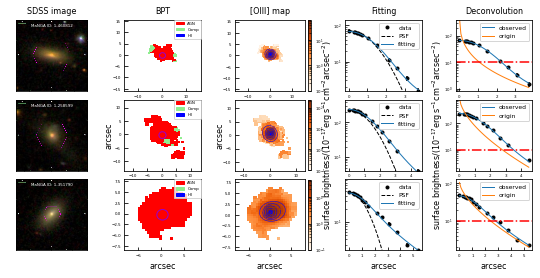

In [4]:
# demo, show the fitting results, used in writing paper
# History:
#    2018-08-03: first edit
#    2018-10-22: update for ppt and paper
#    2019-01-14: update for new data
import warnings
warnings.filterwarnings("ignore") # default or ignore
import matplotlib.backends.backend_pdf as mpdf
from astropy.modeling.models import Gaussian1D
from astropy.io import fits
from scipy import optimize, signal
from matplotlib import pyplot as plt
from ppxf import capfit
import matplotlib.backends.backend_pdf as mpdf
from mangatools.fitmaps import FitMaps


def psf_func(r, amplitude=0, mean=0, stddev=0):
    return amplitude * np.exp(-(r-mean)**2/(2*stddev**2))

def psf_kernel(fwhm, interv=1, data_points=50):
    edge = data_points/(2*interv)
    r = np.arange(-edge, edge+interv, interv)
    sigma = fwhm/2.35482
    return np.exp(-r**2/(2*sigma**2))

def fmodel_conv(x, r, basemodel, psf_fwhm=None, points=50, scale_factor=1.5):
    # used for convolution
    r_interp = np.linspace(r.min(), 1.5*r.max(), points)
    flux = basemodel(x, r_interp)
    psf = psf_kernel(psf_fwhm, r_interp[1]-r_interp[0])
    flux_sym = np.array([flux[::-1], flux]).flatten()
    flux_conv = signal.fftconvolve(flux_sym, psf, mode='same')/np.sum(psf)
    return np.interp(r, r_interp, flux_conv[len(flux_sym)//2:])

fm_dir = '/Volumes/Lacie2/ENLR/fitmaps/'
fm_binned_dir = '/Volumes/Lacie2/ENLR/fitmaps_binned/'

targets = ['8241-9102', '8464-6101', '8720-1901']

pdf = mpdf.PdfPages('results/checkfitting_example-{}.pdf'.format(today))
SB = 10
err_list = []
fs = 4

fig = plt.figure(figsize=(8, 4))
ax0 = fig.subplots(1, 5)

for i in range(5):
    ax0[i].spines['top'].set_color('none')
    ax0[i].spines['bottom'].set_color('none')
    ax0[i].spines['left'].set_color('none')
    ax0[i].spines['right'].set_color('none')
    ax0[i].tick_params(axis='both', labelcolor='w', top='off', bottom='off', left='off', right='off', labelsize=2)

ax = fig.subplots(3, 5)
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, hspace=0.12, wspace=0.45)

if True:
    for i in range(len(targets)):
        plateifu = targets[i]
        print("====================================================")
        print("plateifu: {}".format(plateifu))
        m = Maps(plateifu)
        psf = m.psf
        fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)
        
        with fits.open('data/Ellipse_Fitting-2019-03-20.fits') as f:
            data = f[plateifu].data
            header = f[plateifu].header
            # ignore the first point
            r = data['sma']
            I = data['intens']
            I_err = data['intens_err']
            logI = np.log(I)
            logI_err = I_err/I

        # define the model
        baseModel = lambda x, r: np.exp(x[0] - x[1] * r**(1/x[2]))

        # initial value and bounds
        x0 = (logI.max(), 1, 1)
        bounds=((0, np.inf), (0.001, 8), (0.01, 10))

        #*********** fit with de-convolution ****************#
        cost_fun2 = lambda x, r, logy, logy_err, basemodel, psf_fwhm: \
                    np.sum((np.log(fmodel_conv(x, r, basemodel, psf_fwhm)) - logy)**2/logy_err**2)
        res_lsq2 = optimize.minimize(cost_fun2, x0,
                                     args=(r, logI, logI_err, baseModel, psf), 
                                     method='L-BFGS-B', options={'disp':False},
                                     jac='2-point', bounds=bounds)
        #print('sol:', res_lsq2.x)

        if True: # plot to files
            m.image(showImage=False, mini=True, ax=ax[i, 0], fs=fs)
            m.bpt2d(showImage=False, mini=True, ax=ax[i, 1], fs=fs, show_psf=True)
            O3_corr, O3_corr_err = fm.O3map()
            isolist = fitEllipse(O3_corr, ax=ax[i, 2], n=3, mini=True, showContour=False, fs=fs, 
                                 quiet=1, plot=True)
            r_extend = np.linspace(r.min(), r.max(), 50) # for smooth plot
            gauss_psf = psf_func(r_extend, amplitude=I.max(), mean=0, stddev=psf/2.35482)
            gg_fit2 = fmodel_conv(res_lsq2.x, r_extend, baseModel, psf)
            gg_fit2_orig = baseModel(res_lsq2.x, r_extend)
            if 1:
                # the components that fit with convolution
                ax[i,3].tick_params(axis='both', which='major', labelsize=fs)
                ax[i,3].tick_params(axis='both', which='minor', labelsize=fs-1)
                ax[i,3].semilogy(r, I, 'ko', label='data', ms=3)
                ax[i,3].errorbar(r, I, yerr=I_err, marker='None', linestyle='None',
                                 color='k')
                ax[i,3].plot(r_extend, gauss_psf, 'k--', label='PSF', lw=1)
                ax[i,3].plot(r_extend, gg_fit2, label='fitting', lw=1)
                #ax[i, 3].axhline(x=10, linestyle='-.', color='g')
                ax[i,3].legend(loc='upper right', fontsize=fs+2)
                #ax[i,3].set_ylabel(r'flux/(10$^{-17}$erg/s)', fontsize=fs+2)
                ax[i,3].set_ylim(I.min(), 2*I.max())
            if 1:
                # check the origin and the after convolution
                #ax[i,5].set_title('with convolution', fontsize=fs)
                ax[i,4].tick_params(axis='both', which='major', labelsize=fs)
                ax[i,4].tick_params(axis='both', which='minor', labelsize=fs-1)
                ax[i,4].semilogy(r, I, 'ko', ms=3)
                ax[i,4].errorbar(r, I, yerr=I_err, marker='None', linestyle='None', color='k')
                ax[i,4].plot(r_extend, gg_fit2, label='observed', lw=1)
                ax[i,4].plot(r_extend, gg_fit2_orig, label='origin', lw=1)
                #ax[i,5].set_ylim(y.min(), y_fit.max())
                ax[i,4].axhline(y=10, linestyle='-.', color='r')
                ax[i,4].legend(loc='upper right', fontsize=fs+2)
                #plt.suptitle("{}: {}".format(i, plateifu))
    fs = fs+4
    ax[0, 0].set_title('SDSS image', fontsize=fs)
    ax[0, 1].set_title('BPT', fontsize=fs)
    ax[0, 2].set_title('[OIII] map', fontsize=fs)
    ax[0, 3].set_title('Fitting', fontsize=fs)
    ax[0, 4].set_title('Deconvolution', fontsize=fs)
    ax[2, 1].set_xlabel('arcsec', fontsize=fs)
    ax[2, 2].set_xlabel('arcsec', fontsize=fs)
    ax[2, 3].set_xlabel('arcsec', fontsize=fs)
    ax[2, 4].set_xlabel('arcsec', fontsize=fs)
    ax[0, 4].set_ylim(0, 400)
    ax[1, 4].set_ylim(0, 600)
    ax[1, 4].set_ylim(0, 800)
    
    ax0[1].set_ylabel('arcsec', fontsize=fs)
    ax0[2].set_ylabel('arcsec', fontsize=fs)
    ax0[3].set_ylabel(r'surface brightness/${\rm (10^{-17}erg\,s^{-1}cm^{-2}arcsec^{-2})}$', fontsize=fs)
    ax0[4].set_ylabel(r'surface brightness/${\rm (10^{-17}erg\,s^{-1}cm^{-2}arcsec^{-2})}$', fontsize=fs)
    plt.show(fig)
    fig.savefig('./results/psf_demo.pdf', bbox_inches='tight')
set_matplotlib_formats('png')